In [1]:
import pandas as pd
import numpy as np
import pdb
import datetime
import warnings
from chinese_calendar import is_workday
from datetime import timedelta
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# load data
weather= pd.read_csv('天气数据2018.csv')
# weather.info()

In [3]:
# drop missing data
weather.dropna(axis=1, how='any', inplace=True)
# weather.info()

In [4]:
# drop 'rain'
weather.drop(['rain'], axis=1, inplace=True)
# weather.info()

In [5]:
# integrate day&time to datetime, as index
date_time = weather['day'].astype(str) + ' ' + weather['time'].astype(str)
weather.index = pd.to_datetime(date_time)

In [6]:
# add electric load
load = pd.read_excel('负荷数据2018.xlsx')
load.index = pd.to_datetime(load['time'])
load.drop(['time'], axis=1, inplace=True)
# load_2018

In [7]:
# concat weather factors and load
data_1 = pd.concat((weather, load), axis=1, join='outer')

In [8]:
# interpolate
data_1['load'].interpolate(inplace=True)

In [9]:
# numerization
wea_unique = ['局部多云', '多云', '晴朗', '阴天', '晴天', '大雪', '周边零星小雨', '小雨夹雪', '小雨',
       '零星小雨', '细雨', '有时中雨', '中雨', '大雨', '中到大阵雨', '小阵雨', '周边雷暴', '零星细雨',
       '零星雷雨', '暴阵雨', '有时大雨']
win_unique = ['微风', '和风', '轻风', '清风', '强风', '软风', '劲风', '大风', '烈风', '狂风', '无风',
       '暴风', '台风']
dir_unique = ['北风', '东北风', '东风', '东南风', '西南风', '西北风', '南风', '西风', '-']

def numerization(datum):
#     pdb.set_trace()
    datum['wea'] = float(wea_unique.index(datum.wea) + 1)
    datum['tem'] = float(datum.tem.replace('℃', ''))
    datum['hum'] = float(datum.hum.replace('%', ''))
    datum['win'] = float(win_unique.index(datum.win) + 1)
    datum['dir'] = float(dir_unique.index(datum.dir) + 1)
    datum['winclass'] = float(datum.winclass.replace('级', '').replace('-', '1'))
    datum['tembody'] = float(datum.tembody.replace('℃', ''))
    return datum

data_2 = data_1.apply(numerization, axis=1)

In [10]:
# day type, weekday/weekend/holiday
# season type,
def add_day_type(datum):
#     pdb.set_trace()
    date = datetime.datetime.strptime(datum.day, '%Y/%m/%d')
    datum['daytype'] = float(is_workday(date)) + 1
    datum['seasontype'] = float((date.month-1)//3 + 1)
    return datum
data_3 = data_2.apply(add_day_type, axis=1)

In [11]:
# max/min weather indicators
def max_min(datum):
    datum['max_tem'] = max(datum['tem'])
    datum['min_tem'] = min(datum['tem'])
    datum['max_hum'] = max(datum['hum'])
    datum['min_hum'] = min(datum['hum'])
    datum['max_winclass'] = max(datum['winclass'])
    datum['min_winclass'] = min(datum['winclass'])
    datum['max_tembody'] = max(datum['tembody'])
    datum['min_tembody'] = min(datum['tembody'])
    return datum
data_groupby_day = data_3.groupby(['day'])
data_4 = data_groupby_day.apply(max_min)

In [14]:
# add history data
tmp = pd.DataFrame(columns=['wea_1', 'tem_1', 'hum_1', 'win_1', 'dir_1', 'winclass_1', 'tembody_1',
                           'wea_2', 'tem_2', 'hum_2', 'win_2', 'dir_2', 'winclass_2', 'tembody_2',
                           'load_1', 'load_2', 'load_3', 'load_4', 'load_5', 'load_6', 'load_7', 'load_8',
                           'load_1_day', 'load_2_day', 'load_3_day', 'load_4_day', 'load_5_day', 'load_6_day',
                           'load_1_week', 'load_2_week', 'load_3_week',
                           'GDP', 'GDP_rate', '2_add_value', '3_add_value', '2_ratio', '3_ratio', 'av_GDP', 'urban_ratio'])
data_5 = pd.concat([data_4, tmp], sort=False)

In [15]:
# add history weather data
for index, row in data_4.iterrows():
#     pdb.set_trace()
    index_1 = index - timedelta(hours=1)
    try:
        data_5.loc[index, ['wea_1', 'tem_1', 'hum_1', 'win_1', 'dir_1', 'winclass_1', 'tembody_1']] = data_4.loc[index_1, ['wea', 'tem', 'hum', 'win', 'dir', 'winclass', 'tembody']].values
    except:
        pass
    index_2 = index - timedelta(hours=2)
    try:
        data_5.loc[index, ['wea_2', 'tem_2', 'hum_2', 'win_2', 'dir_2', 'winclass_2', 'tembody_2']] = data_4.loc[index_2, ['wea', 'tem', 'hum', 'win', 'dir', 'winclass', 'tembody']].values
    except:
        pass


In [26]:
# add history load data
data_6 = data_5.copy()
data_6.loc[1:,'load_1'] = data_5['load'][0:-1].values
data_6.loc[2:,'load_2'] = data_5['load'][0:-2].values
data_6.loc[3:,'load_3'] = data_5['load'][0:-3].values
data_6.loc[4:,'load_4'] = data_5['load'][0:-4].values
data_6.loc[5:,'load_5'] = data_5['load'][0:-5].values
data_6.loc[6:,'load_6'] = data_5['load'][0:-6].values
data_6.loc[7:,'load_7'] = data_5['load'][0:-7].values
data_6.loc[8:,'load_8'] = data_5['load'][0:-8].values
data_6.loc[24:,'load_1_day'] = data_5['load'][0:-24].values
data_6.loc[48:,'load_2_day'] = data_5['load'][0:-48].values
data_6.loc[72:,'load_3_day'] = data_5['load'][0:-72].values
data_6.loc[96:,'load_4_day'] = data_5['load'][0:-96].values
data_6.loc[120:,'load_5_day'] = data_5['load'][0:-120].values
data_6.loc[144:,'load_6_day'] = data_5['load'][0:-144].values
data_6.loc[168:,'load_1_week'] = data_5['load'][0:-168].values
data_6.loc[336:,'load_2_week'] = data_5['load'][0:-336].values
data_6.loc[504:,'load_3_week'] = data_5['load'][0:-504].values

In [32]:
data_6

,day,time,wea,tem,hum,win,dir,winclass,tembody,load,...,load_2_week,load_3_week,GDP,GDP_rate,2_add_value,3_add_value,2_ratio,3_ratio,av_GDP,urban_ratio
2018-01-01 00:00:00,2018/1/1,0:00,1.0,1.0,18.0,1.0,1.0,3.0,0.0,5459.5557,...,NaN,NaN,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-01 01:00:00,2018/1/1,1:00,1.0,1.0,18.0,1.0,1.0,3.0,-1.0,5444.7930,...,NaN,NaN,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-01 02:00:00,2018/1/1,2:00,1.0,0.0,18.0,1.0,1.0,3.0,-1.0,5446.9130,...,NaN,NaN,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-01 03:00:00,2018/1/1,3:00,1.0,0.0,18.0,1.0,1.0,3.0,-1.0,5444.6343,...,NaN,NaN,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-01 04:00:00,2018/1/1,4:00,1.0,0.0,18.0,1.0,1.0,3.0,-2.0,5444.3090,...,NaN,NaN,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2018/12/31,19:00,1.0,-3.0,15.0,3.0,4.0,2.0,-4.0,8333.8530,...,7946.94,8393.95,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-12-31 20:00:00,2018/12/31,20:00,1.0,-3.0,15.0,3.0,4.0,2.0,-3.0,8072.4900,...,7873.13,8295.9,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-12-31 21:00:00,2018/12/31,21:00,1.0,-4.0,15.0,3.0,4.0,2.0,-4.0,8106.0405,...,7269.82,8027.7,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-12-31 22:00:00,2018/12/31,22:00,1.0,-4.0,16.0,3.0,4.0,2.0,-4.0,8331.2280,...,6610.91,7857.83,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5


In [28]:
data_6['GDP'] = 30320.0
data_6['GDP_rate'] = 6.6
data_6['2_add_value'] = 5647.7
data_6['3_add_value'] = 24553.6
data_6['2_ratio'] = 4.2
data_6['3_ratio'] = 7.3
data_6['av_GDP'] = 14.0
data_6['urban_ratio'] = 86.5

In [16]:
data_6.iloc[:, 2:] = data_6.iloc[:, 2:].astype(float)
data_6.drop(['day','time'], axis=1, inplace=True)

In [19]:
data_7 = data_6.dropna()
data_7.to_csv('data2018.csv', index_label='time')

In [40]:
data_7

,wea,tem,hum,win,dir,winclass,tembody,load,daytype,seasontype,...,load_2_week,load_3_week,GDP,GDP_rate,2_add_value,3_add_value,2_ratio,3_ratio,av_GDP,urban_ratio
2018-01-22 00:00:00,6.0,-2.0,59.0,4.0,3.0,5.0,-5.0,5372.1816,2.0,1.0,...,5559.6650,5459.5557,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-22 01:00:00,4.0,-2.0,69.0,4.0,3.0,5.0,-6.0,5374.9150,2.0,1.0,...,5576.2275,5444.7930,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-22 02:00:00,6.0,-3.0,80.0,4.0,3.0,5.0,-7.0,5455.6772,2.0,1.0,...,5569.5860,5446.9130,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-22 03:00:00,6.0,-4.0,81.0,4.0,3.0,5.0,-7.0,5524.3980,2.0,1.0,...,5566.1387,5444.6343,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-01-22 04:00:00,6.0,-4.0,82.0,4.0,3.0,5.0,-7.0,5505.5370,2.0,1.0,...,5580.6484,5444.3090,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,1.0,-3.0,15.0,3.0,4.0,2.0,-4.0,8333.8530,1.0,4.0,...,7946.9370,8393.9470,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-12-31 20:00:00,1.0,-3.0,15.0,3.0,4.0,2.0,-3.0,8072.4900,1.0,4.0,...,7873.1313,8295.9040,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-12-31 21:00:00,1.0,-4.0,15.0,3.0,4.0,2.0,-4.0,8106.0405,1.0,4.0,...,7269.8210,8027.7020,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5
2018-12-31 22:00:00,1.0,-4.0,16.0,3.0,4.0,2.0,-4.0,8331.2280,1.0,4.0,...,6610.9146,7857.8267,30320.0,6.6,5647.7,24553.6,4.2,7.3,14.0,86.5


In [84]:
data_new = data_5[['day','max_tem','load']]

In [85]:
data_new_group = data_new.groupby('day')
def agg(group):
    tmp_df = group[['max_tem','load']].mean()
    return tmp_df
data_ = data_new_group.apply(agg)

In [86]:
mean_scaler = lambda x: (x-min(x)) / (max(x)-min(x))
data_ = data_.apply(mean_scaler)

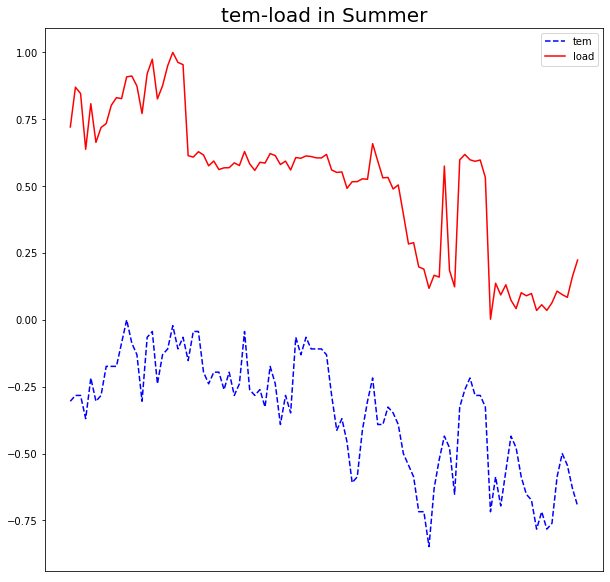

In [95]:
# max_tem 与 load之间关系
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(-data_.max_tem[100:200], 'b--',label='tem')
plt.plot(data_.load[100:200], 'r-',label='load')
plt.legend()
plt.xticks([])
# plt.show()
plt.title('tem-load in Summer', fontsize=20)
plt.savefig('夏季温度与负荷关系.png')

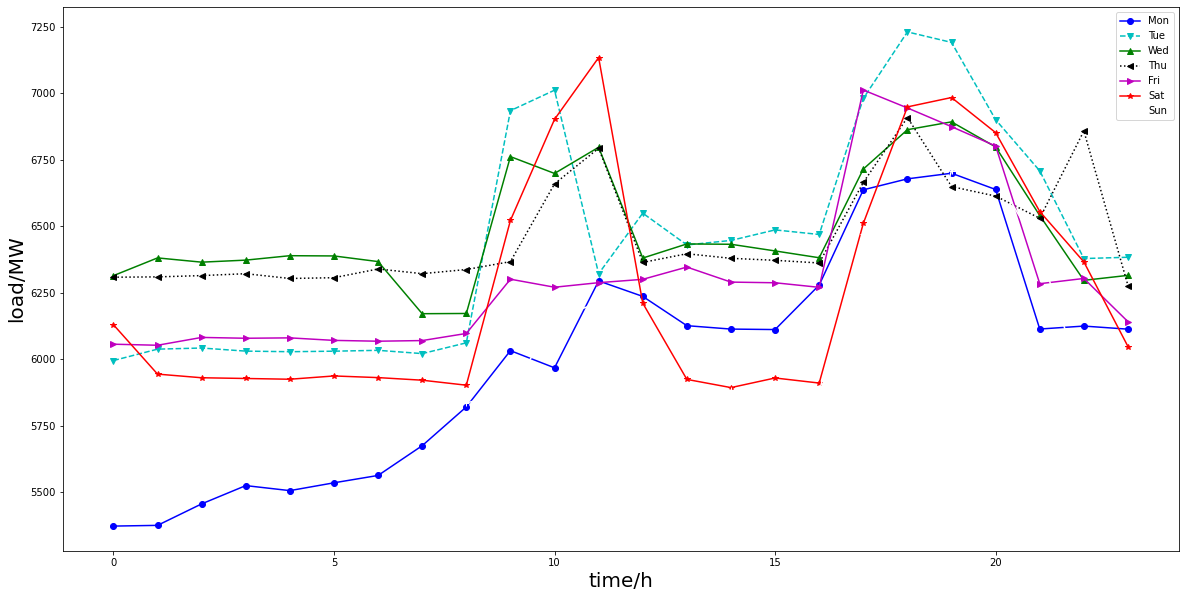

In [57]:
# 周一周二负荷变化
x = [i for i in range(24)]
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(x, data_7.load[0:24], 'b-o',label='Mon')
ax.plot(x, data_7.load[24:48], 'c--v',label='Tue')
ax.plot(x, data_7.load[48:72], 'g-^',label='Wed')
ax.plot(x, data_7.load[72:96], 'k:<',label='Thu')
ax.plot(x, data_7.load[96:120], 'm->',label='Fri')
ax.plot(x, data_7.load[120:144], 'r-*',label='Sat')
ax.plot(x, data_7.load[144:168], 'w-+',label='Sun')
ax.set_xlabel('time/h', fontsize=20)
ax.set_ylabel('load/MW', fontsize=20)
ax.legend()
plt.savefig('一周变化.png')

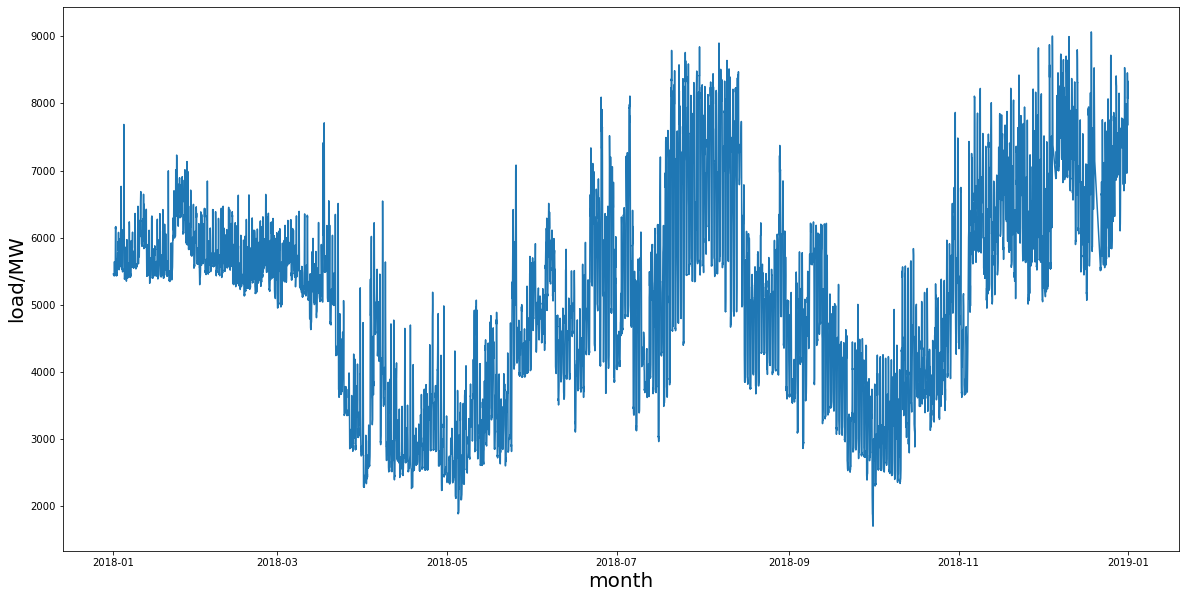

In [69]:
x = [i for i in range(1, 13, 1)]
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(data_5.load)
ax.set_xlabel('month', fontsize=20)
ax.set_ylabel('load/MW', fontsize=20)
plt.savefig('一年变化.png')

In [64]:
data_

,max_tem,load
day,,
2018/1/1,0.173913,0.586740
2018/1/10,0.021739,0.674780
2018/1/11,0.130435,0.673856
2018/1/12,0.152174,0.664333
2018/1/13,0.152174,0.584310
...,...,...
2018/9/5,0.847826,0.420300
2018/9/6,0.717391,0.292965
2018/9/7,0.717391,0.388335


In [96]:
data_7.columns

Index(['wea', 'tem', 'hum', 'win', 'dir', 'winclass', 'tembody', 'load',
       'daytype', 'seasontype', 'max_tem', 'min_tem', 'max_hum', 'min_hum',
       'max_winclass', 'min_winclass', 'max_tembody', 'min_tembody', 'wea_1',
       'tem_1', 'hum_1', 'win_1', 'dir_1', 'winclass_1', 'tembody_1', 'wea_2',
       'tem_2', 'hum_2', 'win_2', 'dir_2', 'winclass_2', 'tembody_2', 'load_1',
       'load_2', 'load_3', 'load_4', 'load_5', 'load_6', 'load_7', 'load_8',
       'load_1_day', 'load_2_day', 'load_3_day', 'load_4_day', 'load_5_day',
       'load_6_day', 'load_1_week', 'load_2_week', 'load_3_week', 'GDP',
       'GDP_rate', '2_add_value', '3_add_value', '2_ratio', '3_ratio',
       'av_GDP', 'urban_ratio'],
      dtype='object')